In [40]:
import matplotlib.pyplot as plt
from datetime import datetime, time
from dateutil.relativedelta import relativedelta
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ta, os, re
import mplfinance as mpf
from itertools import product
import numpy as np

from tqdm import tqdm

In [41]:
from src.DataUpdateModule import DataUpdateModule
from src.Strategy import Strategy
from src.DayTrade import DayTrade
DUM = DataUpdateModule(options_interval_minutes = 5)
strategy = Strategy()

In [42]:
# Find list of available data
available_data = list()
for x in os.listdir("./data/"):
    date = re.search(r"\d{8}", x).group(0)
    date = datetime(int(date[:4]), int(date[4:6]), int(date[6:]))
    available_data.append(date)
available_data_counts = pd.Series(available_data).value_counts()
available_data = available_data_counts[available_data_counts == 2].index.tolist()

In [43]:
trading_months = [datetime(2022, 2, 1) + relativedelta(months = x) for x in range(11)]

In [44]:
AUM = 6.5 * 1e6
DAYs = [pd.NA]
MODELs = [pd.NA]
PNLs = [pd.NA]
AUMs = [AUM]

all_actual_trades = list()
trade_summary = list()

for trade_month in trading_months:
    print(f"===== {trade_month} =====")
    # Find best model in past month
    past_month = trade_month - relativedelta(months = 1)
    trade_days = [x for x in available_data if x.year == past_month.year and x.month == past_month.month]

    ## trade
    models_AUM = [AUM] * len(strategy.get_models())
    all_all_trades = list()
    for trade_day in trade_days:
        df_stock, df_options = DUM.read_data(trade_day)
        strategy.compute_tech_indicators(df_stock)
        all_trades = list()
        for model_num in tqdm(range(len(strategy.get_models()))):
            DT = DayTrade(strategy, model_num = model_num, AUM = models_AUM[model_num], df_options = df_options, commission_dollars = 0.15, max_risk = 0.025, interval = 5)
            trades = DT.trade()
            models_AUM[model_num] += trades.loc[:, "pnl"].sum() if len(trades) > 0 else 0
            all_trades.append(trades)
        param_pnl = pd.DataFrame([strategy.get_models(x) | {"pnl" : all_trades[x]["pnl"].sum(), "model_num" : x} for x in range(len(all_trades))]).assign(day = trade_day)
        all_all_trades.append(param_pnl)
    all_all_trades = pd.concat(all_all_trades)
    all_all_trades.to_csv(f"./results/past_mth_test_{past_month.strftime('%Y-%m')}.csv")
    ## best model
    ratio = dict()
    for model_num in all_all_trades.loc[:, "model_num"].unique():
        df_plot = all_all_trades[all_all_trades.loc[:, "model_num"] == model_num]
        ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()
    model_rankings = pd.Series(ratio).sort_values(ascending = False)
    model_rankings.to_csv(f"./results/past_mth_test_rankings_{past_month.strftime('%Y-%m')}.csv")
    best_model = model_rankings.index[0]
    print(f"Model selected from {past_month.strftime('%Y-%m')}: {best_model}:{round(model_rankings.iloc[0], 3)}")

    # Actual trading
    trade_days = [x for x in available_data if x.year == trade_month.year and x.month == trade_month.month]

    for trade_day in trade_days:
        # Get information
        df_stock, df_options = DUM.read_data(trade_day)
        strategy.compute_tech_indicators(df_stock)

        # Trade
        DT = DayTrade(strategy, model_num = best_model, AUM = AUMs[-1], df_options = df_options, commission_dollars = 0.15, max_risk = 0.025, interval = 5)
        trades = DT.trade()
        pnl = trades.loc[:, "pnl"].sum() if len(trades) > 0 else 0
        AUM = AUMs[-1] + pnl

        # Saving data
        DAYs.append(trade_day)
        MODELs.append(best_model)
        PNLs.append(pnl)
        AUMs.append(AUM)
        all_actual_trades.append(trades)
        trade_summary.append(strategy.get_models(best_model) | {"pnl" : trades.loc[:, "pnl"].sum(), "model_num" : best_model, "day" : trade_day})

        # Print
        print(f"{trade_day.strftime('%Y-%m-%d')} : AUM = {format(round(AUM), ",")}")

trade_summary = pd.DataFrame(trade_summary)
trade_summary.to_csv(f"./results/trade_summary")
all_actual_trades = pd.concat(all_actual_trades)
all_actual_trades.to_csv(f"./results/trading_mth_test_{trade_month.strftime('%Y-%m')}.csv")

===== 2022-02-01 00:00:00 =====


100%|██████████| 64/64 [00:06<00:00,  9.36it/s]
C:\Users\Jian\AppData\Local\Temp\ipykernel_8400\4098037303.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()


Model selected from 2022-01: 58:0.541
2022-02-04 : AUM = 6,499,541
2022-02-11 : AUM = 6,481,221
2022-02-18 : AUM = 6,478,465
2022-02-25 : AUM = 6,478,460
===== 2022-03-01 00:00:00 =====


100%|██████████| 64/64 [00:06<00:00, 10.06it/s]
C:\Users\Jian\AppData\Local\Temp\ipykernel_8400\4098037303.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()


Model selected from 2022-02: 40:0.34
2022-03-04 : AUM = 6,460,675
2022-03-11 : AUM = 6,492,055
2022-03-18 : AUM = 6,483,360
2022-03-25 : AUM = 6,450,823
===== 2022-04-01 00:00:00 =====


100%|██████████| 64/64 [00:06<00:00, 10.50it/s]
C:\Users\Jian\AppData\Local\Temp\ipykernel_8400\4098037303.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()


Model selected from 2022-03: 51:0.565
2022-04-01 : AUM = 6,461,435
2022-04-08 : AUM = 6,455,877
2022-04-22 : AUM = 6,474,232
2022-04-29 : AUM = 6,479,070
===== 2022-05-01 00:00:00 =====


100%|██████████| 64/64 [00:06<00:00, 10.25it/s]
C:\Users\Jian\AppData\Local\Temp\ipykernel_8400\4098037303.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()


Model selected from 2022-04: 35:0.722
2022-05-06 : AUM = 6,453,999
2022-05-13 : AUM = 6,465,883
2022-05-20 : AUM = 6,487,276
2022-05-27 : AUM = 6,505,135
===== 2022-06-01 00:00:00 =====


100%|██████████| 64/64 [00:06<00:00, 10.26it/s]
C:\Users\Jian\AppData\Local\Temp\ipykernel_8400\4098037303.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()


Model selected from 2022-05: 19:1.558
2022-06-03 : AUM = 6,500,260
2022-06-10 : AUM = 6,498,465
2022-06-17 : AUM = 6,503,428
2022-06-24 : AUM = 6,501,729
===== 2022-07-01 00:00:00 =====


100%|██████████| 64/64 [00:05<00:00, 11.84it/s]
C:\Users\Jian\AppData\Local\Temp\ipykernel_8400\4098037303.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()


Model selected from 2022-06: 47:1.015
2022-07-01 : AUM = 6,499,638
2022-07-08 : AUM = 6,498,950
2022-07-15 : AUM = 6,498,800
2022-07-22 : AUM = 6,498,336
2022-07-29 : AUM = 6,499,844
===== 2022-08-01 00:00:00 =====


100%|██████████| 64/64 [00:06<00:00, 10.49it/s]
C:\Users\Jian\AppData\Local\Temp\ipykernel_8400\4098037303.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()


Model selected from 2022-07: 2:0.315
2022-08-05 : AUM = 6,515,586
2022-08-12 : AUM = 6,482,674
2022-08-19 : AUM = 6,491,778
2022-08-26 : AUM = 6,409,527
===== 2022-09-01 00:00:00 =====


100%|██████████| 64/64 [00:05<00:00, 10.72it/s]
C:\Users\Jian\AppData\Local\Temp\ipykernel_8400\4098037303.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()


Model selected from 2022-08: 30:0.865
2022-09-02 : AUM = 6,406,989
2022-09-09 : AUM = 6,409,791
2022-09-16 : AUM = 6,401,574
2022-09-23 : AUM = 6,408,390
2022-09-30 : AUM = 6,406,825
===== 2022-10-01 00:00:00 =====


100%|██████████| 64/64 [00:07<00:00,  8.76it/s]
C:\Users\Jian\AppData\Local\Temp\ipykernel_8400\4098037303.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()


Model selected from 2022-09: 15:0.43
2022-10-07 : AUM = 6,408,523
2022-10-14 : AUM = 6,392,216
2022-10-21 : AUM = 6,393,748
2022-10-28 : AUM = 6,393,764
===== 2022-11-01 00:00:00 =====


100%|██████████| 64/64 [00:06<00:00, 10.63it/s]
C:\Users\Jian\AppData\Local\Temp\ipykernel_8400\4098037303.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()


Model selected from 2022-10: 33:8.749
2022-11-04 : AUM = 6,379,982
2022-11-11 : AUM = 6,380,583
2022-11-18 : AUM = 6,437,812
2022-11-25 : AUM = 6,472,442
===== 2022-12-01 00:00:00 =====


100%|██████████| 64/64 [00:03<00:00, 16.55it/s]
C:\Users\Jian\AppData\Local\Temp\ipykernel_8400\4098037303.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()


Model selected from 2022-11: 32:0.988
2022-12-02 : AUM = 6,512,090
2022-12-09 : AUM = 6,415,795
2022-12-16 : AUM = 6,389,698
2022-12-23 : AUM = 6,268,948
2022-12-30 : AUM = 6,223,439


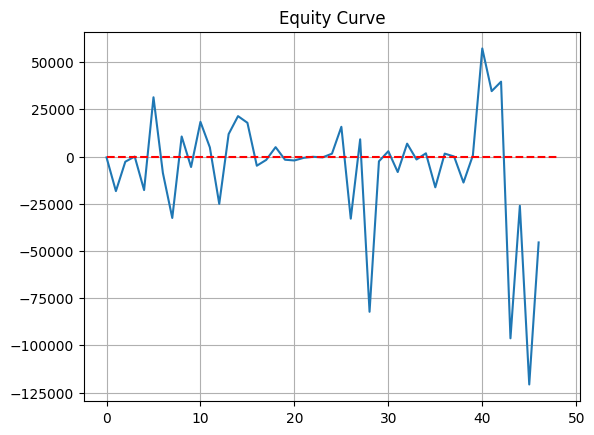

In [60]:
plt.title("Equity Curve")
plt.grid()
plt.plot(pd.Series(PNLs).dropna().values.astype(float))
plt.hlines(y = 0, xmin = 0, xmax = len(PNLs), linestyle = "--", color = "red")